# Домашнее задание к лекции 2

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 4 разных методов получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

### Подготовка кода для ДЗ.2

In [1]:
import pandas as pd

In [2]:
news = pd.read_csv("C:/Users/flath\Desktop/Ml.b/materials.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("C:/Users/flath\Desktop/Ml.b/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


## 1. Получаем векторные представления новостей

In [18]:
#!pip install gensim 


In [5]:
from gensim.corpora.dictionary import Dictionary

In [17]:
#!pip install razdel
#!pip install pymorphy2

In [7]:
import nltk
from nltk.corpus import stopwords

In [19]:
#!pip install nltk

In [13]:
from nltk.tokenize import word_tokenize

In [20]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [23]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\flath\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [24]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [27]:
with open('C:/Users/flath/Desktop/Ml.b/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [28]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [29]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-28-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 28.6 s


In [30]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 42s


In [31]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [32]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [33]:
from gensim.models import LdaModel

In [34]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 33.9 s


In [35]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [36]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(4, 0.034616176),
 (7, 0.29597673),
 (8, 0.23860049),
 (11, 0.065815724),
 (14, 0.03194108),
 (15, 0.24486898),
 (19, 0.07205814)]

In [37]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: температура расчёт характерный выходной южный рекорд аэропорт
topic_1: год цена рынок это млн экономика вырасти
topic_2: рак сотня звезда фрагмент известный билет кость
topic_3: год который рубль статья это фонд человек
topic_4: производитель испытание планета ступень двигатель кожа одежда
topic_5: это ребёнок система риск человек восток который
topic_6: врач налог организм доход депутат сектор параметр
topic_7: это который год всё мочь весь свой
topic_8: выяснить пенсия год миссия это солнце район
topic_9: смерть остров суд иск берег миллиард бизнесмен
topic_10: украина год компания украинский страна который млрд
topic_11: экипаж продукция климат ск питание порт методика
topic_12: год это который рост человек весь мочь
topic_13: журнал писать это мочь всё дыра свой
topic_14: офицер выяснить инцидент тело лечение больница отреагировать
topic_15: физика мышь заведение хороший золото кольцо учебный
topic_16: ракета погибнуть район пострадать произойти авария вода
topic_17: газ с

In [38]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [39]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.024409,0.0,0.0,0.0,0.967465,0.000000,0.0,0.0,0.000000,0.000000
1,4896,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.219800,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.591103
2,4897,0.0,0.000000,0.0,0.0,0.034617,0.0,0.000000,0.295981,0.238687,...,0.244861,0.0,0.0,0.0,0.071960,0.000000,0.0,0.0,0.000000,0.000000
3,4898,0.0,0.054709,0.0,0.0,0.000000,0.0,0.042251,0.400738,0.000000,...,0.114819,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.324657,0.000000
4,4899,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.416719,0.049546,0.0,0.0,0.000000,0.000000


#### Следующий шаг - векторные представления пользователей

In [40]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [41]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [42]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [43]:
get_user_embedding(user_articles_list)

array([0.        , 0.00352233, 0.        , 0.11089037, 0.        ,
       0.03627443, 0.00991594, 0.11209333, 0.        , 0.        ,
       0.06698184, 0.        , 0.07314568, 0.00996718, 0.00573433,
       0.        , 0.01627606, 0.00604849, 0.06405367, 0.12154681,
       0.09435421, 0.19921472, 0.        , 0.05844731, 0.00195822])

In [44]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.011434,0.044636,0.035627,0.000000,0.057425,0.006110,0.123958,0.037034,...,0.026014,0.006898,0.000000,0.084679,0.024186,0.044844,0.122320,0.0,0.026791,0.005797
1,u108690,0.000000,0.005519,0.007020,0.103418,0.006117,0.048332,0.005513,0.124968,0.012443,...,0.000000,0.012938,0.000000,0.058780,0.078670,0.072677,0.134773,0.0,0.011800,0.000000
2,u108339,0.002969,0.002184,0.009246,0.195333,0.000000,0.029894,0.009944,0.041149,0.010193,...,0.000000,0.056835,0.005239,0.041837,0.089271,0.119961,0.140258,0.0,0.030211,0.006074


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [45]:
target = pd.read_csv("C:/Users/flath/Desktop/Ml.b/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [46]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.011434,0.044636,0.035627,0.000000,0.057425,0.006110,0.123958,0.037034,...,0.006898,0.000000,0.084679,0.024186,0.044844,0.122320,0.0,0.026791,0.005797,0
1,u108690,0.000000,0.005519,0.007020,0.103418,0.006117,0.048332,0.005513,0.124968,0.012443,...,0.012938,0.000000,0.058780,0.078670,0.072677,0.134773,0.0,0.011800,0.000000,1
2,u108339,0.002969,0.002184,0.009246,0.195333,0.000000,0.029894,0.009944,0.041149,0.010193,...,0.056835,0.005239,0.041837,0.089271,0.119961,0.140258,0.0,0.030211,0.006074,1


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [48]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [49]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [50]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.16333967, 0.06657495, 0.31757456, 0.15157743, 0.02051905,
       0.04757222, 0.21306745, 0.0615029 , 0.07073483, 0.23465796])

In [51]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

#### Рассчитаем Precision, Recall, F_score

In [52]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.206608, F-Score=0.639, Precision=0.515, Recall=0.841


In [53]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1561  194]
 [  40  205]]


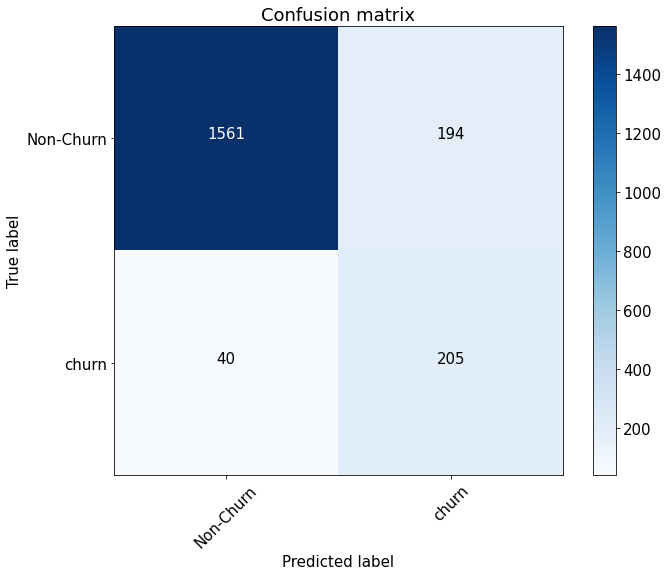

In [54]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [55]:
roc_auc_score(y_test, preds)

0.9366335252049537

#### Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [56]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [57]:
get_user_embedding_median(user_articles_list)

array([0.        , 0.        , 0.        , 0.10531507, 0.        ,
       0.01311761, 0.        , 0.07784742, 0.        , 0.        ,
       0.05340179, 0.        , 0.0180437 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01819111, 0.14892381,
       0.        , 0.13065278, 0.        , 0.02026769, 0.        ])

In [58]:
user_embeddings1 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings1.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings1['uid'] = users['uid'].values
user_embeddings1 = user_embeddings1[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings1.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.0,0.000000,0.000000,0.0,0.031431,0.0,0.080789,0.0,...,0.011816,0.000000,0.0,0.027531,0.000000,0.000000,0.117099,0.0,0.000000,0.0
1,u108690,0.0,0.0,0.000000,0.067589,0.0,0.042065,0.0,0.131998,0.0,...,0.000000,0.000000,0.0,0.025443,0.073969,0.056968,0.130842,0.0,0.000000,0.0
2,u108339,0.0,0.0,0.007917,0.197138,0.0,0.011653,0.0,0.000000,0.0,...,0.000000,0.055154,0.0,0.036127,0.071150,0.136187,0.105411,0.0,0.009027,0.0


In [59]:
X1 = pd.merge(user_embeddings1, target, 'left')
X1.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.0,0.000000,0.000000,0.0,0.031431,0.0,0.080789,0.0,...,0.000000,0.0,0.027531,0.000000,0.000000,0.117099,0.0,0.000000,0.0,0
1,u108690,0.0,0.0,0.000000,0.067589,0.0,0.042065,0.0,0.131998,0.0,...,0.000000,0.0,0.025443,0.073969,0.056968,0.130842,0.0,0.000000,0.0,1
2,u108339,0.0,0.0,0.007917,0.197138,0.0,0.011653,0.0,0.000000,0.0,...,0.055154,0.0,0.036127,0.071150,0.136187,0.105411,0.0,0.009027,0.0,1


In [60]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1[['topic_{}'.format(i) for i in range(25)]], 
                                                    X1['churn'], random_state=0)

In [61]:
logreg1 = LogisticRegression()
#обучим 
logreg1.fit(X_train1, y_train1)

LogisticRegression()

In [62]:
#наши прогнозы для тестовой выборки
preds1 = logreg1.predict_proba(X_test1)[:, 1]
preds1[:10]

array([0.04659778, 0.01464501, 0.62237146, 0.37441539, 0.04481472,
       0.03459322, 0.17683449, 0.0337418 , 0.04944457, 0.40699117])

Перед расчетом метрик подготовим базу для таблицы сравнения метрик:

In [63]:
metric_list=[[i] for i in [thresholds[ix], fscore[ix], precision[ix], recall[ix]]]
metric_list

[[0.20660766941468678], [0.6387596899224807], [0.515], [0.8408163265306122]]

In [64]:
precision, recall, thresholds = precision_recall_curve(y_test1, preds1)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.289706, F-Score=0.764, Precision=0.701, Recall=0.841


In [65]:
median_metrcs=[thresholds[ix], fscore[ix], precision[ix], recall[ix]]
for i in range(len(metric_list)):
    metric_list[i].append(median_metrcs[i])
metric_list

[[0.20660766941468678, 0.28970614568784475],
 [0.6387596899224807, 0.764378478664193],
 [0.515, 0.7006802721088435],
 [0.8408163265306122, 0.8408163265306122]]

Confusion matrix, without normalization
[[1667   88]
 [  40  205]]


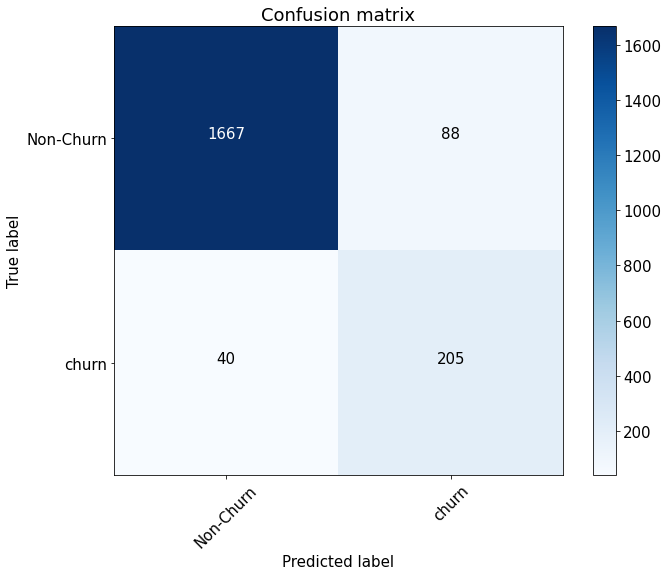

In [66]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test1, preds1>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [67]:
roc_auc_score(y_test1, preds1)

0.9711262282690855

#### Повторим п.2, но используя уже не медиану, а max

In [68]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [69]:
get_user_embedding_max(user_articles_list)

array([0.        , 0.02113397, 0.        , 0.27899453, 0.        ,
       0.09715521, 0.04270377, 0.2958037 , 0.        , 0.        ,
       0.21774343, 0.        , 0.34645775, 0.04752183, 0.02318006,
       0.        , 0.0806604 , 0.03629092, 0.21742859, 0.21659252,
       0.56612527, 0.59202206, 0.        , 0.17655188, 0.01174935])

In [70]:
user_embeddings2 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings2.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings2['uid'] = users['uid'].values
user_embeddings2 = user_embeddings2[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.068607,0.140853,0.213760,0.000000,0.187543,0.036660,0.399467,0.151523,...,0.087067,0.041389,0.000000,0.258487,0.145116,0.174332,0.316933,0.0,0.160747,0.034780
1,u108690,0.000000,0.033115,0.042119,0.280115,0.036702,0.135864,0.018409,0.267123,0.057048,...,0.000000,0.061445,0.000000,0.155586,0.170413,0.182857,0.317401,0.0,0.058247,0.000000
2,u108339,0.017813,0.013102,0.022815,0.332897,0.000000,0.078481,0.059665,0.170377,0.033563,...,0.000000,0.155603,0.031432,0.080916,0.278253,0.195280,0.303294,0.0,0.125008,0.036443


In [71]:
X2 = pd.merge(user_embeddings2, target, 'left')
X2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.068607,0.140853,0.213760,0.000000,0.187543,0.036660,0.399467,0.151523,...,0.041389,0.000000,0.258487,0.145116,0.174332,0.316933,0.0,0.160747,0.034780,0
1,u108690,0.000000,0.033115,0.042119,0.280115,0.036702,0.135864,0.018409,0.267123,0.057048,...,0.061445,0.000000,0.155586,0.170413,0.182857,0.317401,0.0,0.058247,0.000000,1
2,u108339,0.017813,0.013102,0.022815,0.332897,0.000000,0.078481,0.059665,0.170377,0.033563,...,0.155603,0.031432,0.080916,0.278253,0.195280,0.303294,0.0,0.125008,0.036443,1


In [72]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2[['topic_{}'.format(i) for i in range(25)]], 
                                                    X2['churn'], random_state=0)

In [73]:
logreg2 = LogisticRegression()
#обучим 
logreg2.fit(X_train2, y_train2)

LogisticRegression()

In [74]:
#наши прогнозы для тестовой выборки
preds2 = logreg2.predict_proba(X_test2)[:, 1]
preds2[:10]

array([0.01496519, 0.00133826, 0.70408838, 0.02992939, 0.10850784,
       0.04442552, 0.17963293, 0.00935491, 0.00844038, 0.34335821])

In [75]:
precision, recall, thresholds = precision_recall_curve(y_test2, preds2)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.412846, F-Score=0.779, Precision=0.840, Recall=0.727


In [76]:
median_metrcs=[thresholds[ix], fscore[ix], precision[ix], recall[ix]]
for i in range(len(metric_list)):
    metric_list[i].append(median_metrcs[i])
metric_list

[[0.20660766941468678, 0.28970614568784475, 0.4128464616045332],
 [0.6387596899224807, 0.764378478664193, 0.7789934354485777],
 [0.515, 0.7006802721088435, 0.839622641509434],
 [0.8408163265306122, 0.8408163265306122, 0.726530612244898]]

Confusion matrix, without normalization
[[1721   34]
 [  68  177]]


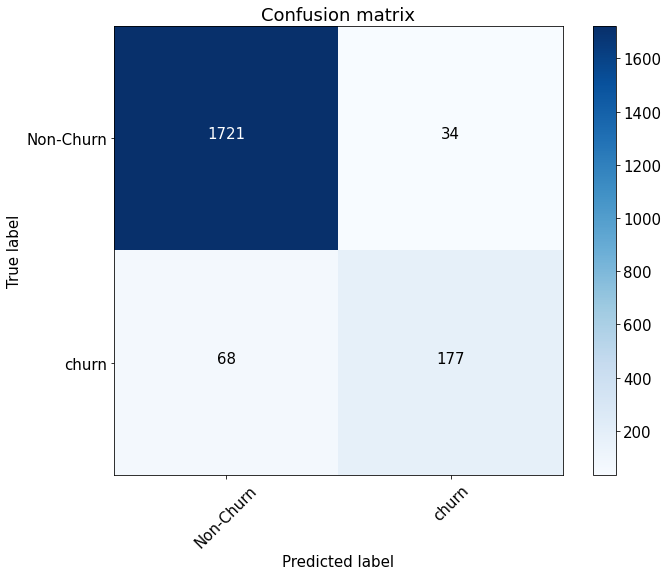

In [77]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test2, preds2>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [78]:
roc_auc_score(y_test2, preds2)

0.966865515436944

#### Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [79]:
metric_df=pd.DataFrame(
    metric_list, columns=['mean','median','max'], index=['Treshhold','F-score','Precision', 'Recall']
).append(pd.DataFrame(
                    [[roc_auc_score(y_test, preds),roc_auc_score(y_test1, preds1),roc_auc_score(y_test2, preds2)]],
    columns=['mean','median','max'],
    index=['ROC-AUC']))
metric_df

,mean,median,max
Treshhold,0.206608,0.289706,0.412846
F-score,0.638760,0.764378,0.778993
Precision,0.515000,0.700680,0.839623
Recall,0.840816,0.840816,0.726531
ROC-AUC,0.936634,0.971126,0.966866


Как видно из таблицы, наиболее эффективным оказался метод с использованием медианы для получения эмбеддинга пользователя, т.к. мы получаем более разреженный вектор заинтересованности пользователя, в следствии того, что что в отличии от среднего и максимального значения, медиана чаще будет равна нулю, на тех темах статей, которые редко появляются в векторе статей читаемых пользователем. То есть интересы пользователя будут выражены наиболее явно.